#HW 2 - Image Filtering (10 pts)
---
For homework assignment HW 2, you will implement some image filters, understand convolution and correlation, and understand the nature of different filters. Feel free to use any necessary function from NumPy, but you cannot just import an advanced library and call existing advanced functions by using only one or two lines of code.

Hint for color image filterings: a filter that works on a single intensity channel (grayscale) can be extended to color channels by treating each color channel (R, G, and B) as an independent grayscale image.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
import cv2 as cv2
import math

Load image and display it. Feel free to load any image you want, but remember to submit your image if you don't use the image that comes with the assignment.

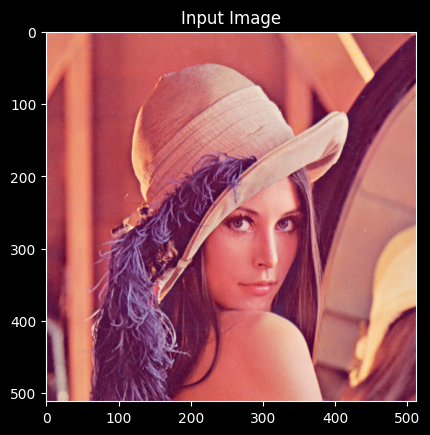

In [26]:
filename = 'Lenna.png'
img_raw = cv2.imread(filename)
H, W, C = img_raw.shape
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.title("Input Image")
plt.imshow(img)
plt.show()



###Task 1 (2 pts)

Implement Gaussian filter to blur the original input image:
1. Select the ideal kernal size separately for sigma=3, 4, 5, 6.
2. Apply Gaussian blurring to the input image with sigma=3, 4, 5, 6 and their corresponding kernel sizes, and visualize all four blurred results.
3. The resulting images have be blurred color images.

(Feel free to change the starter code, or use completely different code)

Text(0.5, 1.0, 'Sigma = 6')

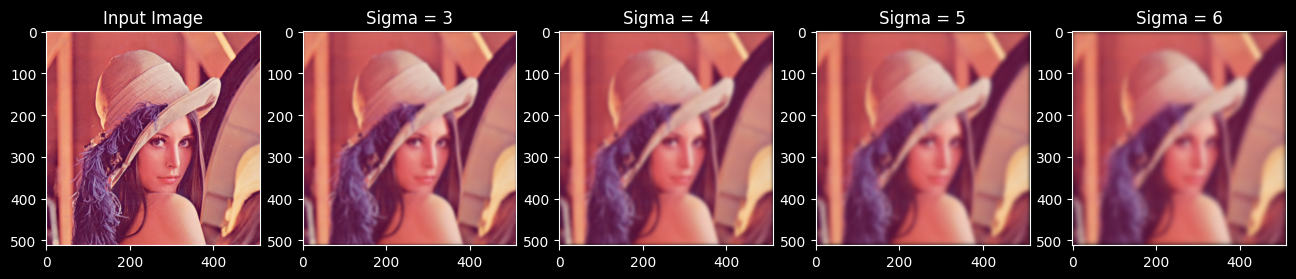

In [27]:
# insert your code here
def gaussian_filter(sigma):
    size = int(2 * np.ceil(sigma * 3) + 1)
    ax_range = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax_range, ax_range)
    filter = (1/2*math.pi*(sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))
    filter = filter / np.sum(filter)
    return filter

def apply_gaussian_filter(img, sigma):
    kernel = gaussian_filter(sigma)
    return apply_kernel(img, kernel)

def apply_kernel(img, kernel):
    k = len(kernel)
    pad = k // 2

    img = img.astype(np.float32)
    padded = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

    output = np.zeros_like(img, dtype=np.float32)

    for i in range(k):
        for j in range(k):
            output += kernel[i, j] * padded[i:i+img.shape[0], j:j+img.shape[1], :]

    return np.clip(output, 0, 255).astype(np.uint8)

plt.figure(figsize=(16,6))

plt.subplot(1,5,1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(1,5,2)
plt.imshow(apply_gaussian_filter(img,sigma=3))
plt.title("Sigma = 3")

plt.subplot(1,5,3)
plt.imshow(apply_gaussian_filter(img,sigma=4))
plt.title("Sigma = 4")

plt.subplot(1,5,4)
plt.imshow(apply_gaussian_filter(img,sigma=5))
plt.title("Sigma = 5")

plt.subplot(1,5,5)
plt.imshow(apply_gaussian_filter(img,sigma=6))
plt.title("Sigma = 6")



###Task 2 (2 pts)

1. Shrink the input image's original dimension to 1/4 (1/4 height and 1/4 width) by Gaussian pyramid (applying Gaussian to the input image and subsampling it by keeping every other pixel for reach iteration). You will have to experimentally determine an appropriate value for $\sigma$ that balances image sharpness with the subsampling's aliasing artifacts. Feel free to display multiple results and compare them, or just display the best result in your opinion.

2. Identify a convolution kernal and implement the convolution (not correlation) process to translate the above resized smaller image 2 pixels towards left (<-).

3. The resulting images have to be color images.

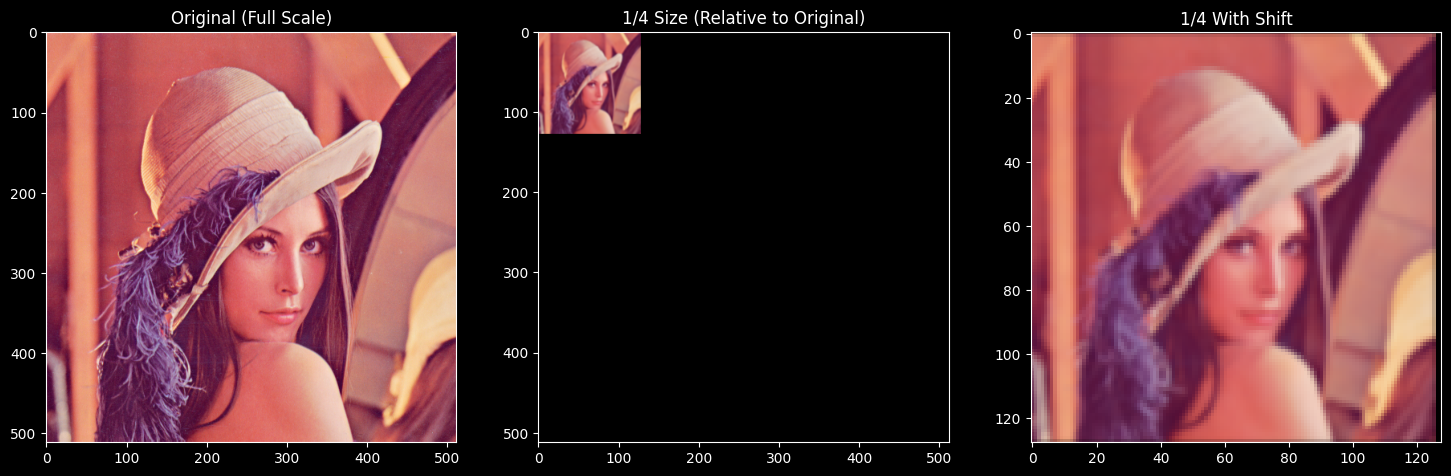

In [31]:
# insert your code here
def subsample(img):
    h, w, c = img.shape
    output = np.zeros((h//2, w//2, c),dtype=np.uint8)
    r = 0
    for i in range(0,h,2):
        c=0
        for j in range(0,w,2):
            output[r][c] = img[i][j]
            c+=1
        r+=1
    return output

def shrink(img,scaling_factor):
    tmp = img.copy()
    for i in range(scaling_factor):
        tmp = apply_gaussian_filter(tmp, sigma=1.5)
        tmp = subsample(tmp)
    return tmp



# kernel and convolution
kernel = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])
kernel = np.flip(kernel)

h, w, _ = img.shape
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Input Image
axes[0].imshow(img)
axes[0].set_title("Original (Full Scale)")

# 2. 1/4 Size
smaller_img = shrink(img, 2)
axes[1].imshow(smaller_img)
# Lock the axes to the ORIGINAL image dimensions
axes[1].set_xlim(0, w)
axes[1].set_ylim(h, 0) # Note: ylim is (max, min) for images
axes[1].set_title("1/4 Size (Relative to Original)")

# 3. 1/4 With Shift
shifted_img = apply_kernel(smaller_img, kernel)
axes[2].imshow(shifted_img)
axes[2].set_title("1/4 With Shift")

for ax in axes:
    ax.grid(False)

###Task 3 (2 pts)

Implement the matching using Normalized Cross-Correlation (NCC) to locate the face within the source image. Use the cropped face from your HW1 as the template for template matching. Visualize the resulting NCC map as a grayscale or pseudo-color heat map. Highlight the detected region in the original image using a bounding box (or anything reasonable/intuitive) at the location of the maximum correlation peak.



Text(0.5, 1.0, 'Template Image')

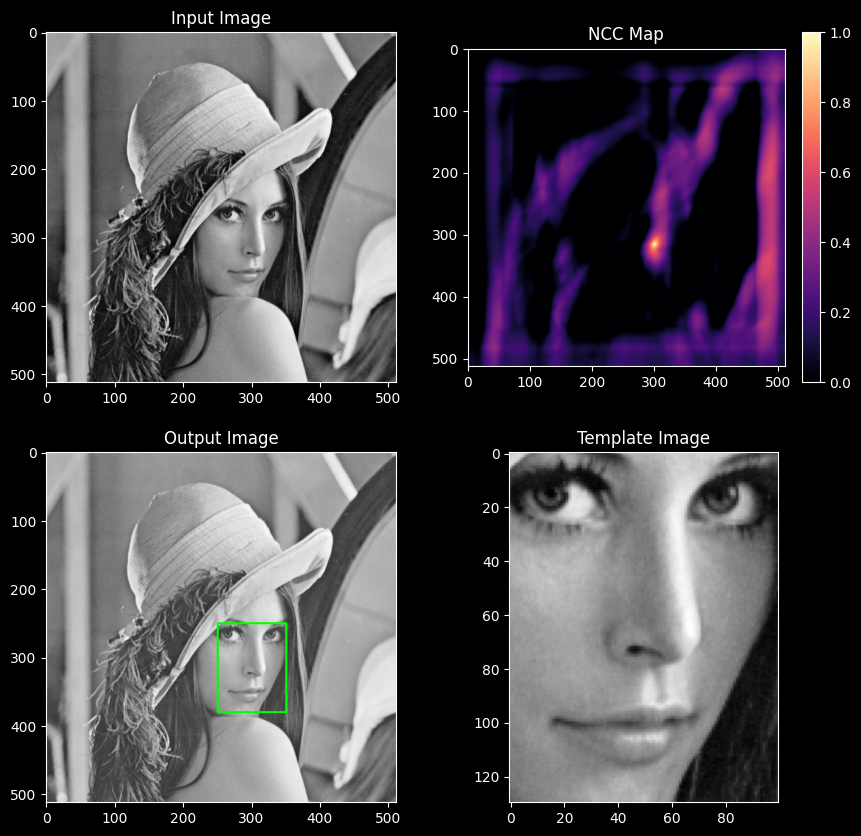

In [32]:
# ncc generates a score map with the same dimension as src
# each cell contains the score value for that particular coordinate
def ncc(src, template):
    th, tw = template.shape

    src = src.astype(np.float32)
    tmp = template.astype(np.float32)

    tmp_mean = np.mean(tmp)
    tmp_centered = tmp - tmp_mean
    tmp_norm = np.sqrt(np.sum(tmp_centered**2))


    # padding
    padded_img = np.pad(src,((th//2,th//2),(tw//2,tw//2)), mode='constant')

    # Note: you might have to convert color value to float for math
    padded_img = padded_img.astype(np.float32)

    # The result size after padding matches the original image size
    res_h, res_w = src.shape
    score_map = np.zeros((res_h, res_w))

    # sliding window process
    for y in range(res_h):
        for x in range(res_w):
            # extract the region of interest from the padded image
            roi = padded_img[y:y+th, x:x+tw]

            roi_mean = np.mean(roi)
            roi_centered = roi - roi_mean
            roi_norm = np.sqrt(np.sum(roi_centered**2))
            # calculate ncc
            denominator = roi_norm * tmp_norm
            if denominator < 1e-5:
                score_map[y,x] = 0
            else:
                numerator = np.sum(roi_centered*tmp_centered)
                score_map[y,x] = numerator/denominator
    return score_map


# Load darkened or brightened Lenna.png from your HW 1
# You can load the darkened or brightened image directly
# or copy and paste your HW 1 code here to darken/brighten the Lenna image as the main_image
main_image = cv2.imread('Lenna_brightened.png')

# template: crop the face from the original Lenna image
template = main_image[250:380,250:350,:]
# or import your face template image
# template = cv2.imread('template_face')

# convert main_image and template to grayscale
main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# get score_map by ncc
score_map = ncc(main_image, template)

# Find the best match coordinates
y, x = np.unravel_index(np.argmax(score_map), score_map.shape)

h, w = template.shape
top_left = (x - w//2, y - h//2)
bottom_right = (x + w//2, y + h//2)

# Visualize the matching box on top of the main image
output = cv2.cvtColor(main_image, cv2.COLOR_GRAY2BGR)
cv2.rectangle(output, top_left, bottom_right, (0, 255, 0), 2)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(main_image, cmap="gray")
plt.title("Input Image")

plt.subplot(2,2,2)
im = plt.imshow(score_map,cmap="magma", vmin=0, vmax=1)
plt.title("NCC Map")
plt.colorbar(im, fraction=0.05, pad=0.05)

plt.subplot(2,2,3)
plt.imshow(output)
plt.title("Output Image")

plt.subplot(2,2,4)
plt.imshow(template, cmap="gray")
plt.title("Template Image")

###Task 4 (2 pts)

Identify and implement the most effective spatial filter discussed in class to remove the salt&pepper noise in image "Lenna_noise.png". The resulting image has to be a color image.

In [ ]:
# insert your code here

###Task 5 (2 pts)

Identify and implement the most effective spatial filter discussed in class to remove the freckles but preserve the edges in image "Face_freckles.jpeg". The resulting image has to be a color image. (You will likely have to experimentally determine an appropriate value for some of the parameters. Feel free to display multiple results and compare them, or just display the best result in your opinion.)